## 1. 패키지 로드

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

## 2. 데이터 로드

In [2]:
train = pd.read_csv('data/train.csv')
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')
train.head(2)

# 'index_col'은 해당 열(PassengerId)을 인덱스로 사용할 수 있게 해줌.
# but 고유한 값이어야 함.

test = pd.read_csv('data/test.csv', index_col='PassengerId')
submission = pd.read_csv('data/gender_submission.csv', index_col='PassengerId')

print(train.shape, test.shape, submission.shape)

# shape: 해당 데이터 행렬의 크기 -> (행 숫자, 열 숫자)
# 즉 우리는 train의 891명의 데이터로, test의 418명의 생존여부를 예측해, submission 행렬의 크기에 맞춰 결과를 제출해야함.

(891, 11) (418, 10) (418, 1)


## 3. 데이터 분석 시작

### 3.0. 관련 배경지식이나 '이름' column을 활용하여 가설 수립

### 3.1. 타겟 변수 확인
맞춰야 하는 데이터 = 타겟 변수 (= 종속 변수)

한쪽으로 치우친 타겟 변수가 지나치게 많은 경우를 'Class imbalabced problem'이라 한다.  

카드 사기 거래 여부, 하늘에서 운석이 떨어지는 경우를 예를 들어 보면  
사기가 아닌 경우, 운석이 떨어지지 않는 경우가 압도적으로 많다.  

이때 별다른 처리 없이 머신러닝에게 데이터를 학습시킨다면,  
머신러닝이 모든 데이터를 0이라고 예측할지도 모른다.  
그리고 이 정확도를 보면, 상당히 높게 나온다.
하지만 이는 **의미없는 머신러닝 모델**이다.  

이럴 때는 여러 방법들을 통해 이 불균형을 해결한 후 머신러닝 알고리즘으로 학습을 시켜야 의미있는 예측을 한다.

Survived
0    549
1    342
Name: count, dtype: int64

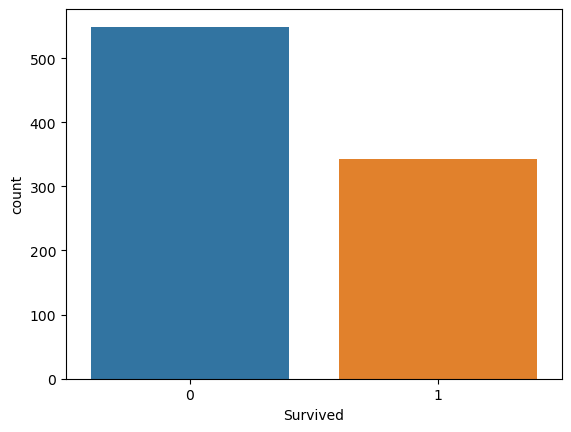

In [4]:
sns.countplot(train, x='Survived')

train['Survived'].value_counts()

### 3.2. 결측치 처리
데이터를 삭제하거나, 주변값 또는 대표값으로 결측치를 채워 넣는 방식으로 결측치를 처리한다.

In [5]:
print(train.isnull().sum())
print(test.isnull().sum())

train=train.drop(columns='Cabin')
test=test.drop(columns='Cabin')

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


In [20]:
test.loc[test['Fare'].isnull(),'False']=0

### 3.3. 성별

<Axes: xlabel='Sex', ylabel='count'>

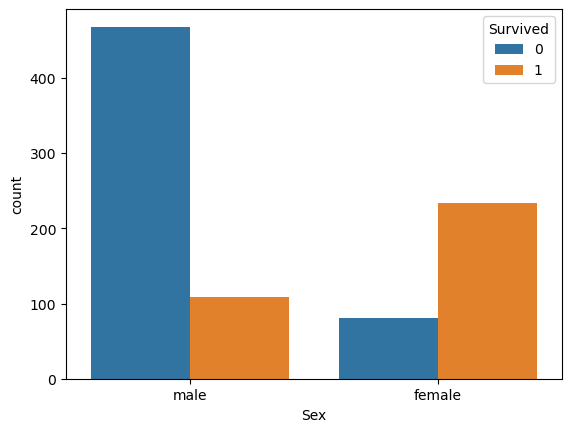

In [6]:
sns.countplot(train, x='Sex', hue='Survived')
# train 데이터를 사용하고, x축에는 '성별'을 'Survived' 항목으로 구분해서 나누어본다

In [7]:
# 성별 데이터 인코딩
# 문자를 인식하지 못하는 ML 알고리즘을 위해 문자데이터를 숫자(0,1)로 변환해주는 작업
train.loc[train['Sex']=='male', 'Sex'] = 0
train.loc[train['Sex']=='female', 'Sex'] = 1
test.loc[test['Sex']=='male', 'Sex'] = 0
test.loc[test['Sex']=='female', 'Sex'] = 1

### 3.4. Pclass

<Axes: xlabel='Pclass', ylabel='count'>

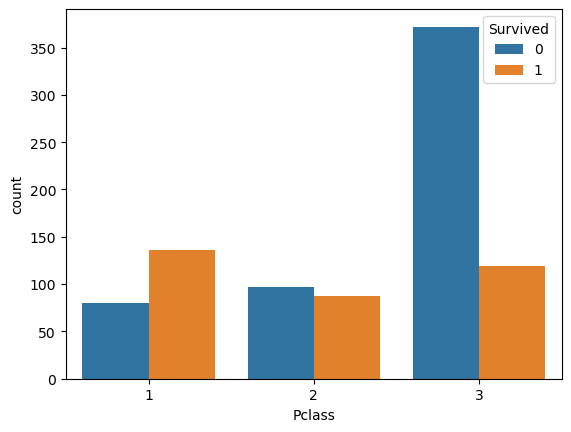

In [8]:
sns.countplot(data=train, x='Pclass', hue='Survived')

1 2 3 의 객석등급 순으로 사망률이 높다. 이는 좋은 정보다.  
여기서 1,2,3은 수치형 변수의 형태를 하고 있지만, 사실은 범주형 변수다.  
수학계산 과정이 필요한 머신러닝 알고리즘에게 이대로 숫자를 넣어주면 알고리즘은 딱 오해하기 좋다.  
이럴 때 필요한 것이 바로 원-핫 인코딩(one-hot encoding)이다.  

예를 들어보면 아래와 같다.
객실 1등급 여부 : True, False, False, False, ...  
객실 2등급 여부 : False, False, True, False, ...  
객실 3등급 여부 : False, True, False, True, ...  

이렇게 하면 어떻게든 중복이 나오지 않지만,
처리해야할 변수의 갯수가 아주아주 많아진다는 치명적인 단점이 있다.  
이는 Tree 기반의 머신러닝 알고리즘에서는 좋은 영향을 주지 못한다.  
때에 따라 원-핫 인코딩할 변수가 너무 많다면, 그냥 1, 2, 3으로 인코딩하기도 한다.  
(ML 라이브러리 sklearn에서는 이를 'LabelEncoder'로 구현해두었다.)  
상황에 따라 적절한 대처가 필요하다.

In [9]:
# One-hot Encoding
train['Pclass_3']=(train['Pclass']==3)
train['Pclass_2']=(train['Pclass']==2)
train['Pclass_1']=(train['Pclass']==1)

test['Pclass_3']=(test['Pclass']==3)
test['Pclass_2']=(test['Pclass']==2)
test['Pclass_1']=(test['Pclass']==1)

# 필요없는 Pclass 열 삭제
train=train.drop(columns='Pclass')
test=test.drop(columns='Pclass')

### 나이(Age)와 요금(Fare)
나이가 어리면 비싼 요금은 내기 힘들 것이다.  
또한 비싼 요금은 높은 객실 등급과 연관이 클 것이다.  
그렇다면 요금도 객실등급처럼 생존 확률에 유의미한 영향을 미치는가?  

C:\Users\home\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


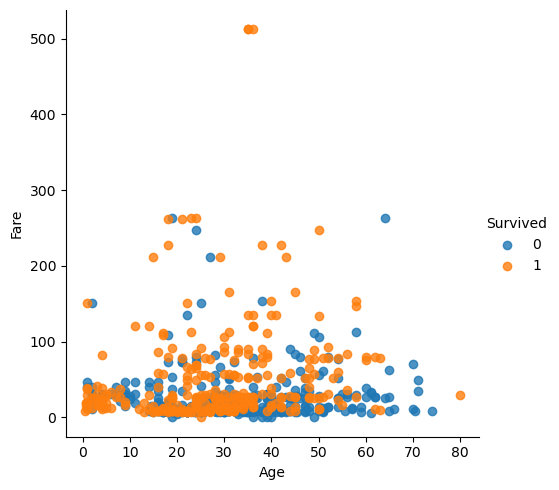

In [12]:
sns.lmplot(data=train, x='Age', y='Fare', fit_reg=False, hue='Survived')
# lmplot
# column 간의 선형관계를 확인하기에 용이한 차트 (outlier 짐작 가능)
# fit_reg 파라미터: 추세선

C:\Users\home\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


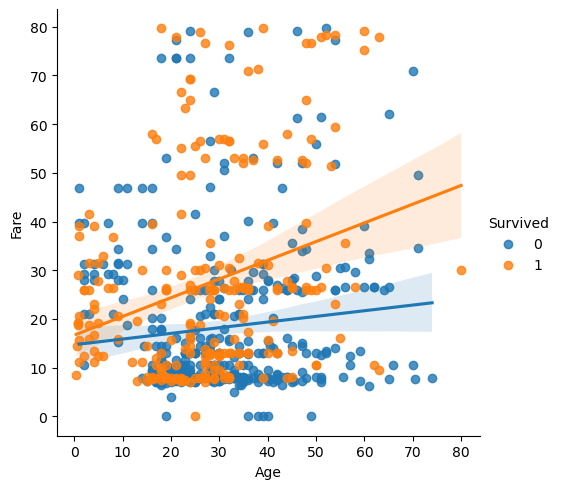

In [19]:
# outlier로 인해 대부분의 결과가 아래에 배치되어 있어
# 유의미한 결과를 보지 못함 → 그래프 확대
LowFare = train[train['Fare']<80]
sns.lmplot(LowFare, x='Age', y='Fare', hue='Survived')

In [21]:
# 확대했음에도 유의미한 결과는 X
# 'Age' 변수 삭제
train = train.drop(columns='Age')
test = test.drop(columns='Age')

### SibSp & Parch
'같이 동행하는 일행'에 대한 정보

<Axes: xlabel='FamilySize', ylabel='count'>

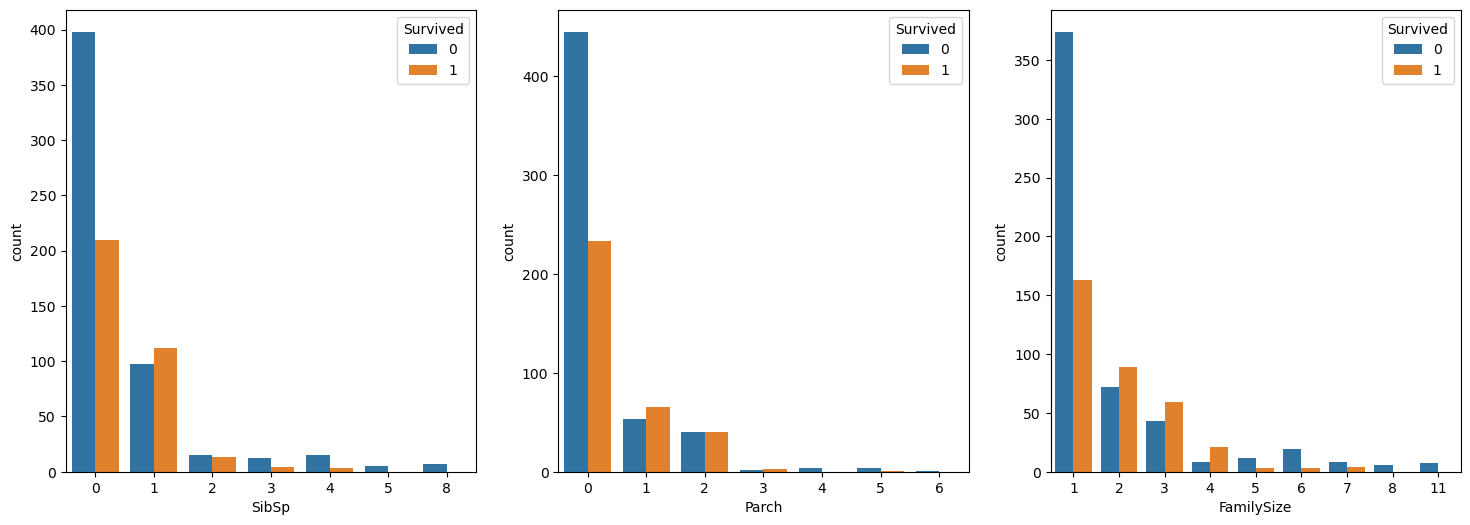

In [22]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18, 6)
sns.countplot(data=train, x='SibSp', hue='Survived', ax=ax1)
sns.countplot(data=train, x='Parch', hue='Survived', ax=ax2)
sns.countplot(data=train, x='FamilySize', hue='Survived', ax=ax3)

FamilySize가 2~4 인 경우 생존률이 더 높음 (핵가족의 전형적인 인원수)  
이들이 빠르게 뭉쳐서 다같이 빠르고 정확한 판단을 해서 생존률이 높은 것인지는 알 수 없지만,  
이들 데이터가 가진 사실은, 이들의 생존률이 높았다는 것이다.

<Axes: xlabel='Extended', ylabel='count'>

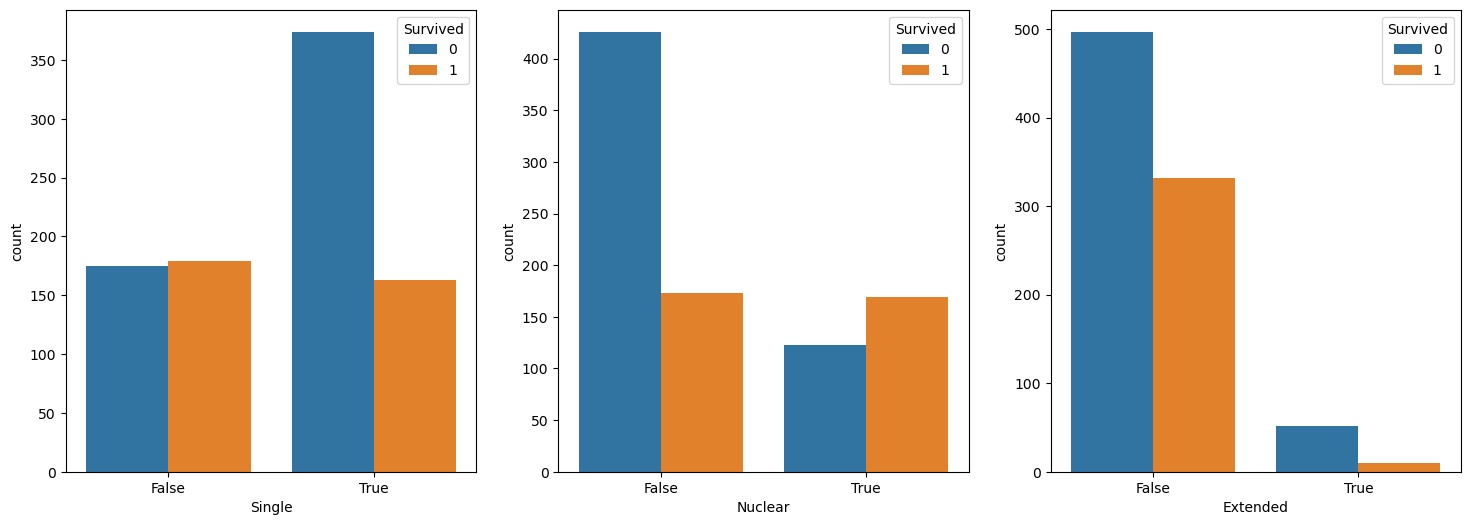

In [23]:
# 다른 가족 규모
train['Single'] = (train['FamilySize']==1)
train['Nuclear'] = (2<=train['FamilySize']) & (train['FamilySize']<=4)
train['Extended'] = train['FamilySize']>=5

test['Single'] = (test['FamilySize']==1)
test['Nuclear'] = (2<=test['FamilySize']) & (test['FamilySize']<=4)
test['Extended'] = test['FamilySize']>=5

figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,6)
sns.countplot(data=train, x='Single', hue='Survived', ax=ax1)
sns.countplot(data=train, x='Nuclear', hue='Survived', ax=ax2)
sns.countplot(data=train, x='Extended', hue='Survived', ax=ax3)

In [24]:
# 핵가족이 True일 때, 즉 핵가족인 경우에만 생존률이 높았음.
# 다른 데이터는 무의미하므로 Nuclear를 제외한 모든 column 삭제
train=train.drop(columns=['Single', 'Extended', 'SibSp', 'Parch', 'FamilySize'])
test=test.drop(columns=['Single', 'Extended', 'SibSp', 'Parch', 'FamilySize'])